In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, widgets
# visulisation function
from functions.visualisations import (
    histogram_trace, plot_linear_data,
    plot_y_timeseries, boxplot_weights,
    plot_ycorr_scatter
)

from types import MethodType


In [7]:


np.random.seed(2023)
class LinearModel:

    def __init__(self) :
        self.w=None
        self.b=None

    def evaluate_proposal(self,data,theta):
        self.encode(theta)
        predictions=self.predict(data)
        return predictions    
    
    def predict(self,x_in):
        y_out=x_in.dot(self.w)+self.b
        return y_out

    def encode(self,theta):
        self.w=theta[0:-1]
        self.b=theta[-1]



In [9]:

        
def likelihood_function(self,theta,tausq,test=False):
    if test:
        x_data=self.x_test
        y_data=self.y_test
    else:
        x_data=self.x_data
        y_data=self.y_data  

    model_prediction=self.model.evaluate_proposal(x_data,theta)
    model_simulation=model_prediction+np.random.normal(0,tausq,size=model_prediction.shape)
    accuracy=self.rmse(model_prediction,y_data)
    log_likelihood = np.sum(-0.5 * np.log(2 * np.pi * tausq) - 0.5 * np.square(y_data - model_prediction) / tausq)
    return [log_likelihood,model_prediction,model_simulation,accuracy]

def prior(self,sigma_squared,nu_1,nu_2,theta,tausq):
    n_params = self.theta_size # number of parameters in model
    part1 = -1 * (n_params / 2) * np.log(sigma_squared)  ####Maybe add 2*np.pi in the log
    part2 = 1 / (2 * sigma_squared) * (sum(np.square(theta)))
    log_prior = part1 - part2 - (1 + nu_1) * np.log(tausq) - (nu_2 / tausq)
    return log_prior

In [10]:
def sampler(self):
    pos_theta = np.ones((self.n_samples, self.theta_size)) 
    # posterior defining the variance of the noise in predictions
    pos_tau = np.ones((self.n_samples, 1))
    pos_eta = np.ones((self.n_samples, 1))
     # record output f(x) over all samples
    pred_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    # record simulated values f(x) + error over all samples 
    sim_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    # record the RMSE of each sample
    rmse_data = np.zeros(self.n_samples)
    # now for test
    test_pred_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_sim_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_rmse_data = np.zeros(self.n_samples)

    theta=np.random.randn(self.theta_size)
    pred_y[0,]=self.model.evaluate_proposal(self.x_data,theta)

    eta=np.log(np.var(pred_y[0,]-self.y_data))
    tausq_proposal=np.exp(eta)

    prior_val=self.prior(self.sigma_squared,self.nu_1,self.nu_2,theta,tausq_proposal)
    [likelihood,pred_y[0,],sim_y[0,],rmse_data[0]]=self.likelihood_function(theta,tausq_proposal)

    n_accept=0

    for ii in np.arange(1,self.n_samples):
        theta_proposal=theta+np.random.normal(0,self.step_theta,self.theta_size)
        eta_proposal=eta + np.random.normal(0,self.step_eta,1)
        tausq_proposal = np.exp(eta_proposal)  

        prior_proposal=self.prior(self.sigma_squared,self.nu_1,self.nu_2,theta_proposal,tausq_proposal)

        [likelihood_proposal, pred_y[ii,], sim_y[ii,], rmse_data[ii]] = self.likelihood_function(
            theta_proposal, tausq_proposal
        )


        [_, test_pred_y[ii,], test_sim_y[ii,], test_rmse_data[ii]] = self.likelihood_function(
            theta_proposal, tausq_proposal, test=True
        )

        diff_likelihood=likelihood_proposal-likelihood
        diff_prior=prior_proposal-prior_val

        mh_prob=min(1,np.exp(diff_likelihood+diff_prior))
        u=np.random.uniform(0,1)
        if u < mh_prob:
            n_accept+=1
            likelihood=likelihood_proposal
            prior_val=prior_proposal
            theta=theta_proposal
            eta=eta_proposal
            pos_theta[ii,] = theta_proposal
            pos_tau[ii,] = tausq_proposal
            pos_eta[ii,] = eta_proposal
        else:
            pos_theta[ii,] = pos_theta[ii-1,]
            pos_tau[ii,] = pos_tau[ii-1,]
            pos_eta[ii,] = pos_eta[ii-1,]

    acceptance_rate=(n_accept/self.n_samples)*100
    print(acceptance_rate)
    self.pos_theta = pos_theta[self.n_burnin:, ]
    self.pos_tau = pos_tau[self.n_burnin:, ] 
    self.pos_eta = pos_eta[self.n_burnin:, ]
    self.rmse_data = rmse_data[self.n_burnin:]

    results_dict = {'w{}'.format(_): self.pos_theta[:, _].squeeze() for _ in range(self.theta_size-1)}
    results_dict['b'] = self.pos_theta[:, -1].squeeze()
    results_dict['tau'] = self.pos_tau.squeeze()
    results_dict['rmse'] = self.rmse_data.squeeze()

    pred_dict = {}
    pred_dict['train_pred'] = pred_y[self.n_burnin:,:]
    pred_dict['train_sim'] = sim_y[self.n_burnin:,:]
    pred_dict['test_pred'] = test_pred_y[self.n_burnin:,:]
    pred_dict['test_sim'] = test_sim_y[self.n_burnin:,:]
    
    results_df = pd.DataFrame.from_dict(
        results_dict
    )

    return results_df,pred_dict




In [11]:
class MCMC:
    def __init__(self,n_samples, n_burnin, x_data, y_data, x_test, y_test):
        self.n_samples = n_samples # number of MCMC samples
        self.n_burnin = n_burnin # number of burn-in samples
        self.x_data = x_data # (N x M)
        self.y_data = y_data # (N x 1)
        self.x_test = x_test # (Nt x num_features)
        self.y_test = y_test # (Nt x 1)

        self.step_theta = 0.02;  
        self.step_eta = 0.01; 

        self.sigma_squared = 5
        self.nu_1 = 1
        self.nu_2 = 0.5

        self.model = LinearModel()
        self.theta_size = x_data.shape[1] + 1

        # store output
        self.pos_theta = None
        self.pos_tau = None
        self.pos_eta = None
        self.rmse_data = None

        # functions defined above - this is poor practice, but done for readability 
        # and clarity
        self.likelihood_function = MethodType(likelihood_function, self)
        self.prior = MethodType(prior, self)
        self.sampler = MethodType(sampler, self)

    def rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())




In [12]:
name="Sunspot"
train_data = np.loadtxt("data/{}/train.txt".format(name))
test_data    = np.loadtxt("data/{}/test.txt".format(name))

print('Training data shape: {}'.format(train_data.shape))


Training data shape: (298, 5)


In [13]:
n_samples=25000
burn_in=int(n_samples*0.25)
data_case='Sunspot'

x_data = train_data[:,:-1]
y_data = train_data[:,-1]
x_test = test_data[:,:-1]
y_test = test_data[:,-1]


mcmc=MCMC(n_samples,burn_in,x_data,y_data,x_test,y_test)
result,pred=mcmc.sampler()

pred_y = pred['train_pred']
sim_y = pred['train_sim']
pred_y_test = pred['test_pred']
sim_y_test = pred['test_sim']


11.192


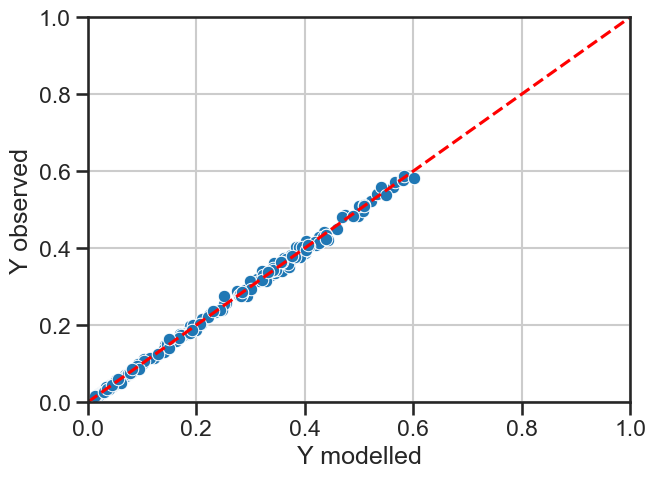

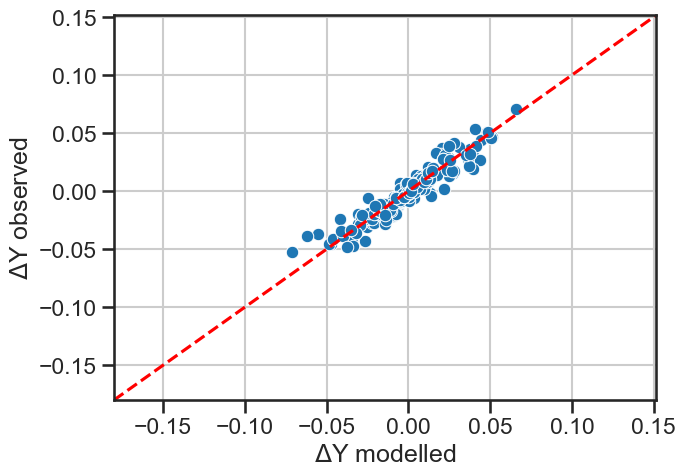

In [14]:
plot_ycorr_scatter(
    y_test,
    pred_y_test
)
plot_ycorr_scatter(
    np.diff(y_test),
    pred_y_test[:,1:] - y_test[:-1],
    minmax=None,
    dy=True
)
